In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

 98% 721M/736M [00:08<00:00, 146MB/s]
100% 736M/736M [00:08<00:00, 94.6MB/s]


In [ ]:
!unzip eye-diseases-classification.zip


Archive:  eye-diseases-classification.zip
  inflating: dataset/cataract/0_left.jpg  
  inflating: dataset/cataract/103_left.jpg  
  inflating: dataset/cataract/1062_right.jpg  
  inflating: dataset/cataract/1083_left.jpg  
  inflating: dataset/cataract/1084_right.jpg  
  inflating: dataset/cataract/1102_left.jpg  
  inflating: dataset/cataract/1102_right.jpg  
  inflating: dataset/cataract/1115_left.jpg  
  inflating: dataset/cataract/1126_right.jpg  
  inflating: dataset/cataract/112_right.jpg  
  inflating: dataset/cataract/1144_left.jpg  
  inflating: dataset/cataract/1144_right.jpg  
  inflating: dataset/cataract/1164_left.jpg  
  inflating: dataset/cataract/1167_right.jpg  
  inflating: dataset/cataract/119_left.jpg  
  inflating: dataset/cataract/1285_left.jpg  
  inflating: dataset/cataract/1415_left.jpg  
  inflating: dataset/cataract/1415_right.jpg  
  inflating: dataset/cataract/1435_left.jpg  
  inflating: dataset/cataract/1444_left.jpg  
  inflating: dataset/cataract/1452_l

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'

In [ ]:
import fnmatch
import os

# image files count
cataract_count = len(fnmatch.filter(os.listdir('./dataset/cataract'), '*.*'))
dre_count = len(fnmatch.filter(os.listdir('./dataset/diabetic_retinopathy'), '*.*'))
glaucoma_count = len(fnmatch.filter(os.listdir('./dataset/glaucoma'), '*.*'))
normal_count = len(fnmatch.filter(os.listdir('./dataset/normal'), '*.*'))
total_image_count = cataract_count + dre_count + \
                    glaucoma_count + normal_count
# print count
print('---Categories---')
print('Cataract:', cataract_count)
print('Diabetic retinopathy:', dre_count)
print('Glaucoma:', glaucoma_count)
print('Normal', normal_count)
print()
print('---Total image count---')
print(total_image_count)

---Categories---
Cataract: 1038
Diabetic retinopathy: 1098
Glaucoma: 1007
Normal 1074

---Total image count---
4217


In [ ]:

# load example image
from PIL import Image 
im = Image.open('./dataset/glaucoma/1495_left.jpg')
# summarize some details about the image
print(im.format)
print(im.mode)
print(im.size) # size already 512 x 512

pixels = np.asarray(im)
print(pixels[0])
print(pixels.shape) # 3 channel last

JPEG
RGB
(512, 512)
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
(512, 512, 3)


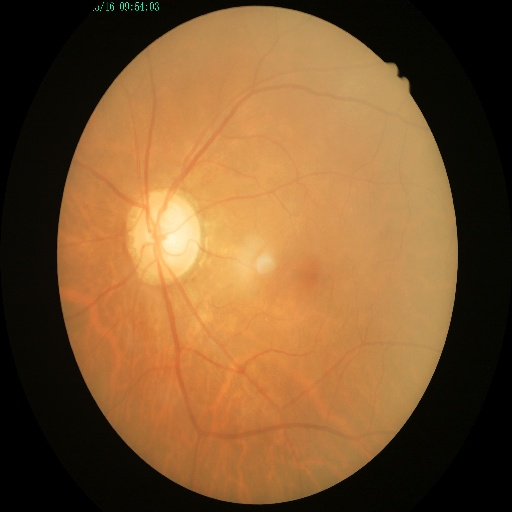

In [ ]:
#Import library
from IPython import display
display.Image(filename='./dataset/glaucoma/1495_left.jpg', width=200, height=150)

In [ ]:
# calculate image pixel mean, min, max

mean = pixels.mean()
print('Mean: %.3f' % mean)
# confirm pixel range is 0-255
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

Mean: 86.173
Min: 0.000, Max: 255.000


In [ ]:
#preprocess image
import tensorflow as tf
from tensorflow.keras import layers
print(tf.__version__) #2.8.2

2.12.0


In [ ]:
resize_and_rescale = tf.keras.Sequential([   
    layers.Resizing(331,331) ,  # needs to be symmetrical, specific size for nasnetlarge
    layers.Rescaling(1./255) # desired height, width in model pipeline
])

result = resize_and_rescale(pixels)
print(result.shape) # new shape, channels

(331, 331, 3)


In [ ]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())


Min and max pixel values: 0.0 1.0


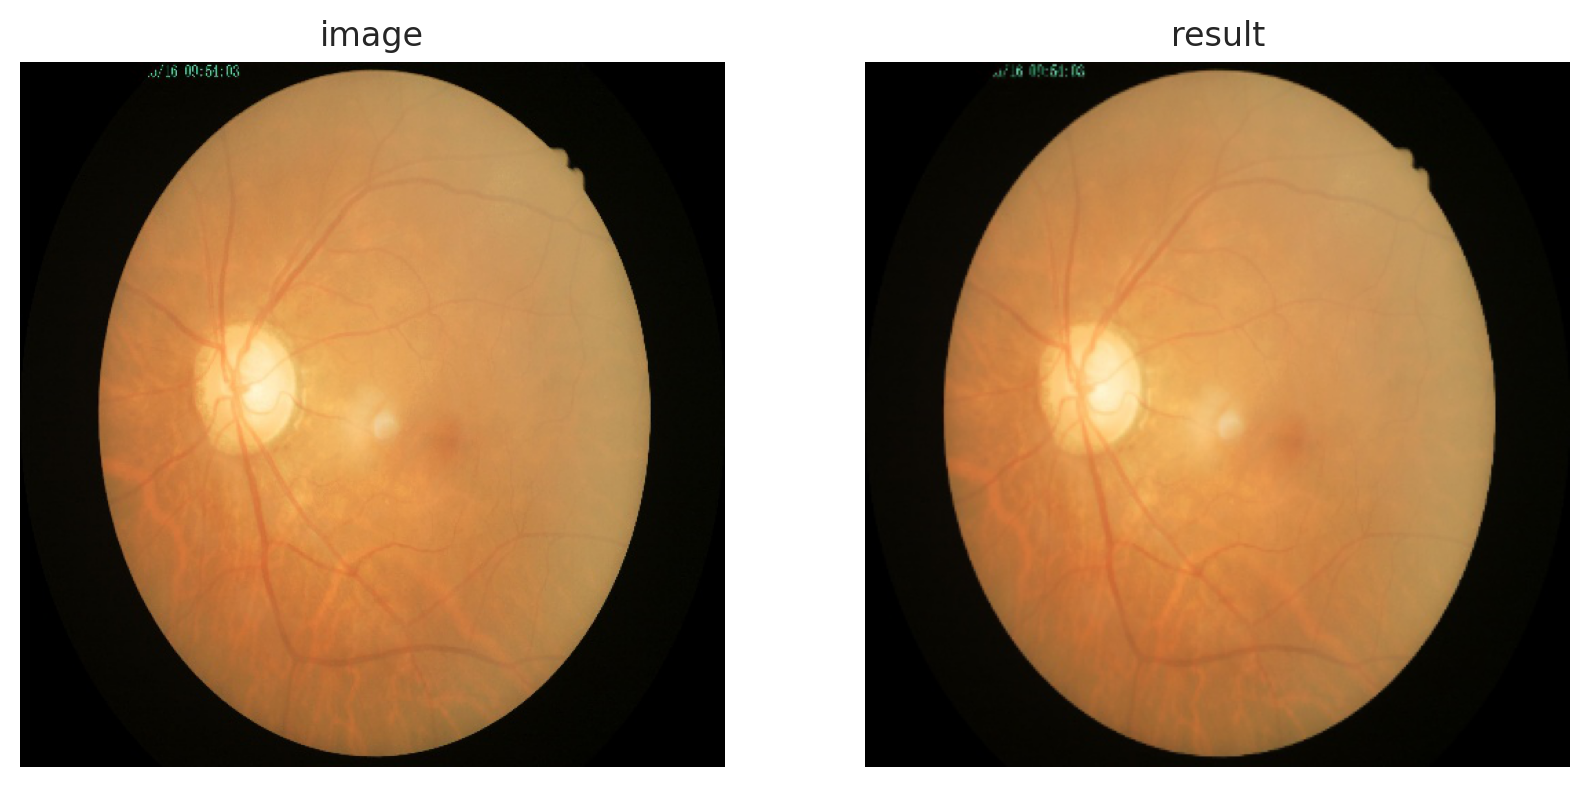

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,8))
ax0.imshow(im)
ax0.axis('off')
ax0.set_title('image')
# after pixel normalisation
ax1.imshow(result)
ax1.axis('off')
ax1.set_title('result')
plt.show() # result seems to have slight blurring of image, but still good definition

In [ ]:
##Create train, validation and test datasets
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# first allocate a test set using this library
import splitfolders

splitfolders.ratio('./dataset/', output="./work_directory/", seed=1, ratio=(.5,.25,.25))

Copying files: 4217 files [00:02, 1447.89 files/s]


In [ ]:
# generate dataset that can be used for machine learning
from tensorflow.keras.utils import image_dataset_from_directory

image_size = (331, 331) # very important to get this right, will determine model success
batch_size = 32

train_ds = image_dataset_from_directory(
    './work_directory/train',
    image_size=image_size,
    shuffle=True,
    labels='inferred',
    seed=1,
    batch_size=batch_size,
    label_mode='categorical'
)

val_ds = image_dataset_from_directory(
    './work_directory/val',
    image_size=image_size,
    shuffle=True,
    labels='inferred',
    seed=1,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = image_dataset_from_directory( # for model evaluation later
    './work_directory/test',
    image_size=image_size,
    labels='inferred',
    seed=1,
    shuffle=False,
    batch_size=batch_size,
    label_mode='categorical'
)

Found 2108 files belonging to 4 classes.
Found 1052 files belonging to 4 classes.
Found 1057 files belonging to 4 classes.


NameError: ignored

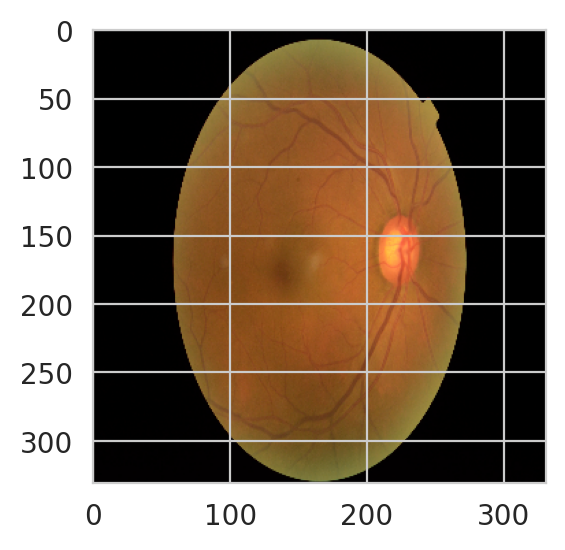

In [ ]:
#Visualise images and labels together


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # each image 160 x 160
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i], axis=0)])
    plt.axis("off")

In [ ]:
#Data augmentation


data_augmentation = tf.keras.Sequential(
    [ layers.RandomFlip("horizontal"), 
      layers.RandomRotation(0.1),
      layers.RandomContrast(0.1)
    ])

In [ ]:
#Visualise augmented images


def augmented_img():
  for image, _ in train_ds.take(1):  # take a sample image from training set
    plt.figure(figsize=(8, 8))
    first_image = image[0]
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
      plt.imshow(augmented_image[0] / 255) # rescale pixel 0 to 1
      plt.axis("off")




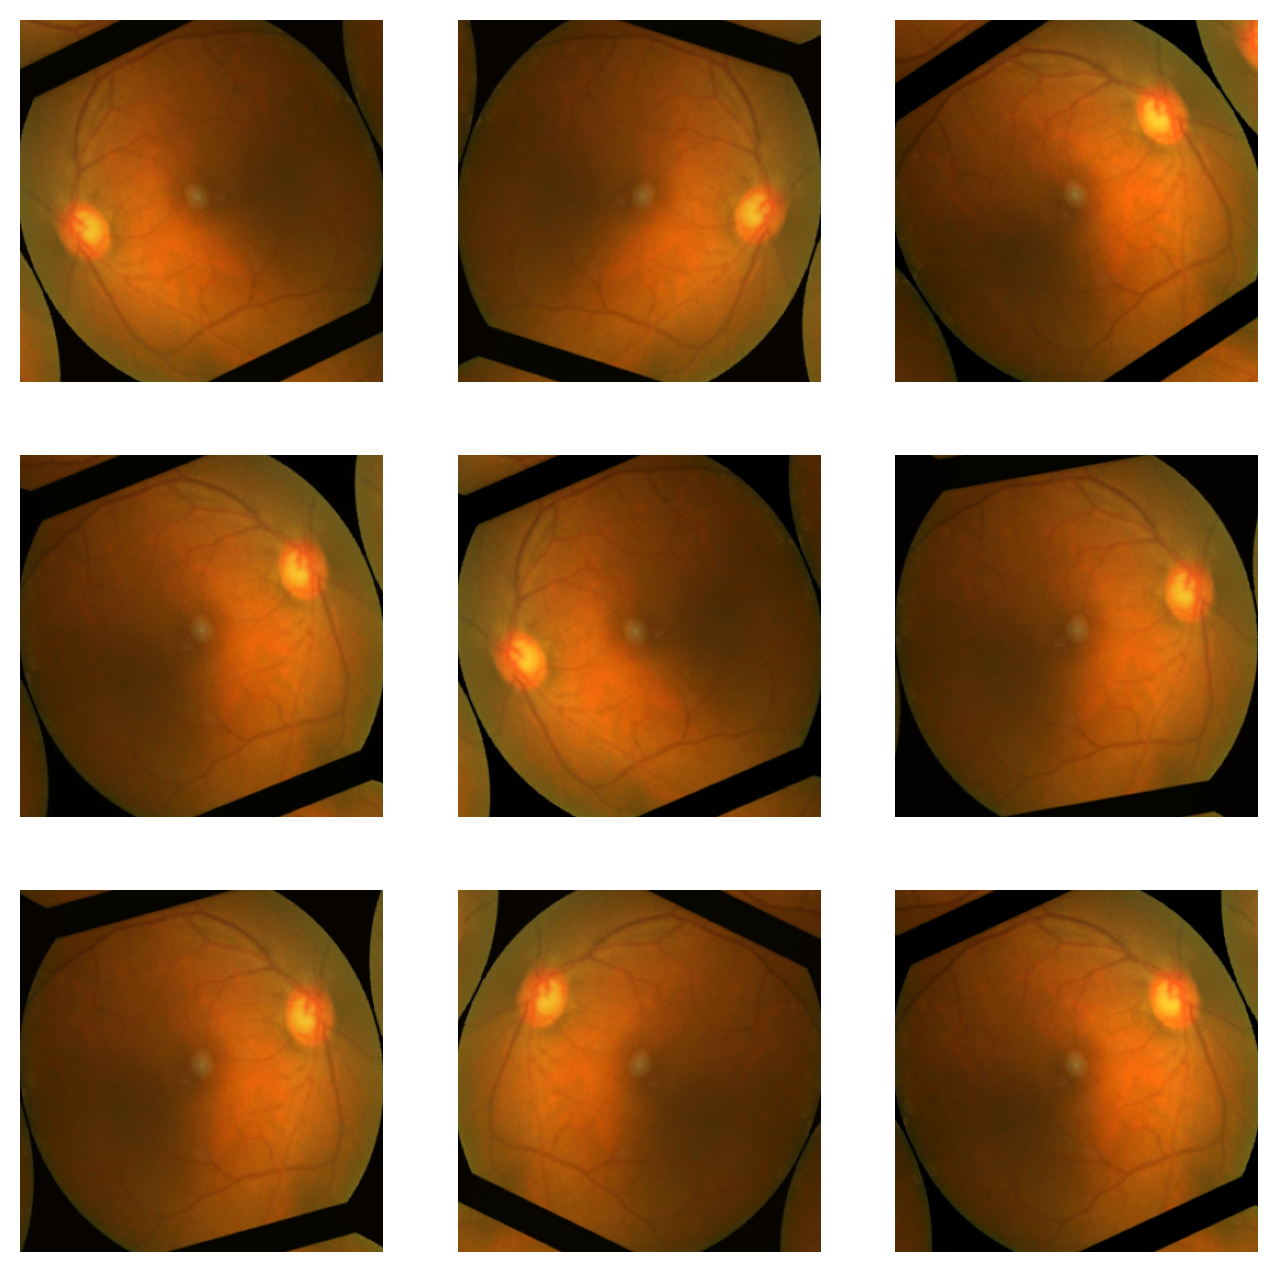

In [ ]:
augmented_img()

In [ ]:
#Create Base NasNetLarge model

#getting F1 score in metrics



import keras.backend as K # function to add F1 score as metric

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*r)

In [ ]:

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score
]

In [ ]:
from tensorflow.keras.layers import (Dense, Activation, Dropout, Conv2D, 
                                     MaxPooling2D, BatchNormalization)
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
     


input_shape = (331, 331, 3)
base_model = tf.keras.applications.NASNetLarge(input_shape=input_shape,
                                                 include_top=False,
                                                 weights='imagenet',
                                                 pooling='max'
                                                 )
base_model.trainable=True # train entire model layers, yet with pre-trained weights from Image

343610240/343610240 [==============================] - 3s 0us/step


In [ ]:
# Create the base model from the pre-trained NASNetLarge model
def NasNetL():
  input_shape = (331, 331, 3)
  base_model = tf.keras.applications.NASNetLarge(input_shape=input_shape,
                                                 include_top=False,
                                                 weights='imagenet',
                                                 pooling='max'
                                                 )
  base_model.trainable=True # train entire model layers, yet with pre-trained weights from ImageNet
  x = base_model.output
  x = tf.keras.layers.Rescaling(1./255)(x) # rescaling layer
  x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
  x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
  x = Dropout(rate=.4, seed=123)(x)       
  output = Dense(4, activation='softmax')(x)
  # instantiate model with added layers
  model=Model(inputs=base_model.input, outputs=output)
  model.compile(tf.keras.optimizers.Adam(learning_rate=0.001), 
                loss='categorical_crossentropy', 
                metrics=METRICS) 
  return model
     


model = NasNetL()
     


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 331, 331, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 165, 165, 96  2592        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 165, 165, 96  384         ['stem_conv1[0][0]']             
                                )                                                             